# State space modeling for the annual flow of river Nile

The first part of this project considers the use of state space models for hydrology applications. The dataset nile.csv contains measurements of the annual flow (in unit of 108 × m3) of the river Nile at Aswan between 1871 to 1970 (source: Table 1 of Cobb 1978).

## 1. Read the river Nile dataset using the read_csv function from the pandas package

In [1]:
import pandas as pd 

dataset = pd.read_csv('nile.csv')
dataset.head()

,flow
0,1120
1,1160
2,963
3,1210
4,1160


## 2. We will use the first 80 measurements from 1871 to 1950 as our training dataset and the last 20 measurements from 1951 to 1970 as our testing dataset. Implement this split.

In [2]:
train = dataset[:80]
test = dataset[80:]

## 3. Plot the time series and observe the apparent changepoint near 1898. Speculate why this might be the case.

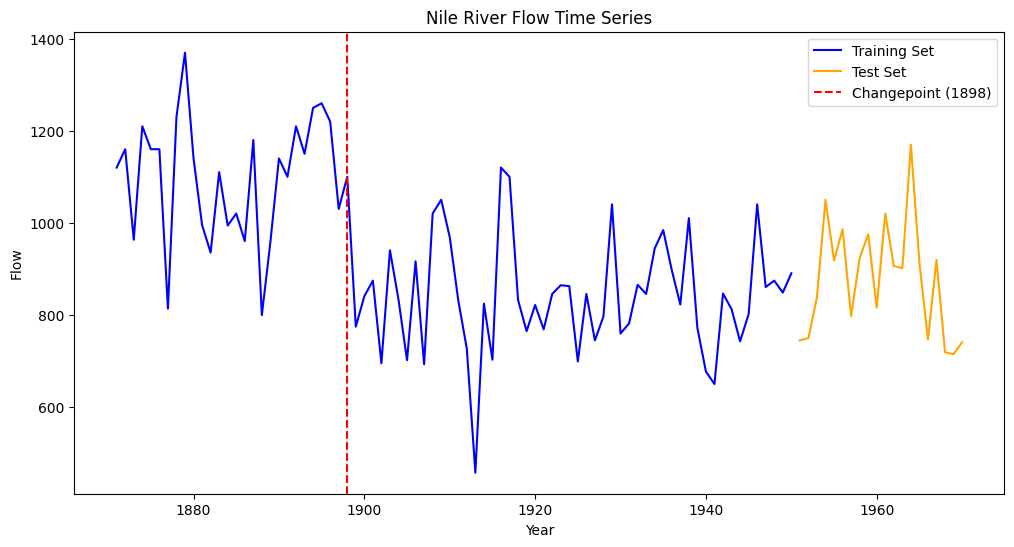

In [3]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.plot([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")
plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

The answer is taken from Wikipedia: 

**Aswan Low Dam, 1898–1902**

*The British began construction of the first dam across the Nile in 1898. Construction lasted until 1902 and the dam was opened on 10 December 1902*.

## 4. We will model the annual flow Xt and its measurement Yt in year t+1871, for t = 0, 1, . . . , 99, using the following univariate linear Gaussian state space model

In [4]:
import numpy as np
from particles import kalman

In [5]:
# first define the linear gaussian model
# dimensions
dx = 1
dy = 1

# initial distribution of X0 ~ N(mu0,Sigma0)
mu0 = np.zeros(dx)
Sigma0 = np.eye(dx)
almost_zero = 1e-15

In [6]:
# Define the initial state distribution
mu0 = 1120
Sigma0 = 1450

# Define the state space model function
def construct_ssm(sigma_X2, sigma_Y2):
    # Transition matrix (identity for univariate case)
    F = np.array([[1]])

    # Covariance matrix for X_t (process noise)
    SigmaX = np.array([[sigma_X2]])

    # Observation matrix (identity for univariate case)
    G = np.array([[1]])

    # Covariance matrix for Y_t (observation noise)
    SigmaY = np.array([[sigma_Y2]])

    # Define the linear Gaussian state space model
    ssm = kalman.MVLinearGauss(F=F, G=G, covX=SigmaX, covY=SigmaY, mu0=np.array([mu0]), cov0=np.array([[Sigma0]]))

    return ssm

We can try is is works : 

In [8]:
# construct model with some parameter values
ssm = construct_ssm(sigma_X2=1, sigma_Y2=20)

## 5. Let y0 , y1 , . . . , y79 denote the 80 measurements from 1871 to 1950 in our training dataset. Using the kalman module from the particles package, write a function that evaluates the log-likelihood log p(y0, y1, . . . , y79|θ) for any θ ∈ (0, ∞)2 with the Kalman filter. This function should take as argument theta a vector of size 2 and output a numerical value.

In [9]:
# learn parameters using maximum likelihood
def loglikelihood(theta,y):
    # get parameters

    sigma_X2, sigma_Y2 = theta

    # construct state space model
    ssm = construct_ssm(sigma_X2, sigma_Y2)

    # run Kalman filtering to evaluate the log-likelihood
    kf = kalman.Kalman(ssm=ssm, data=y)
    kf.filter()

    # return loglikelihood using sum
    return np.sum(kf.logpyt)

## 6. Compute the maximum likelihood estimator

In [11]:
from scipy.optimize import minimize
theta0 = [1450, 1500]
output = minimize(lambda theta: -loglikelihood(theta), theta0, method='Nelder-Mead')

KeyError: 0

In [ ]:
# maximum likelihood estimator 
print("MLE", output.x)

# true parameters
print("True parameters:")
print(["sigma_X", 1, "sigma_Y", 20])

In [ ]:
mle_theta = result.x

In [ ]:
# Using the maximum likelihood estimator for sigma_X^2 and sigma_Y^2
sigma_X2_mle, sigma_Y2_mle = mle_theta

# Construct the state space model with MLE parameters
ssm_mle = construct_ssm(sigma_X2_mle, sigma_Y2_mle)

# Perform Kalman filtering and smoothing
kf = kalman.Kalman(model=ssm_mle)
filtering_means = kf.smooth(y=train).mean
smoothing_means = kf.smoother().mean

# Convert results to arrays
filtering_means = np.array(filtering_means).flatten()
smoothing_means = np.array(smoothing_means).flatten()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Year'], train_measurements, label='Measurements')
plt.plot(train_data['Year'], filtering_means, label='Filtering Mean')
plt.plot(train_data['Year'], smoothing_means, label='Smoothing Mean')
plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow (108 × m3)')
plt.title('Filtering and Smoothing Means of the River Nile Flow')
plt.legend()
plt.show()


****